In [83]:
import os
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

In [84]:
data_dir = "../data"

In [85]:
llama_language_percentages = {
    "en": 0.897,
    "de": 0.0017,
    "es": 0.0013,
    "fr": 0.0016,
    "it": 0.0011,
    "ko": 0.0006,
    "pt": 0.0009,
    "ru": 0.0013,
    "zh": 0.0013,
}

polylm_language_percentages = {
    "en": 0.6756,
    "de": 0.0088,
    "es": 0.0089,
    "fr": 0.0081,
    "it": 0.0069,
    "ko": 0.0013,
    "pt": 0.0068,
    "ru": 0.0121,
    "zh": 0.2214,
}

In [86]:
# Identity Counterfactual
dataset = "vript"
experiment = "identity_counterfactual"

dfs = [
    (
        "Llama 2",
        "Vript",
        "prompt_gradient",
        pd.read_pickle(f"{data_dir}/full/multiling_results_2021_llama-awq_rephrase_vript.pkl"),
    ),
    (
        "PolyLM",
        "Vript",
        "prompt_gradient",
        pd.read_pickle(f"{data_dir}/full/multiling_results_2033_polylm-1.7b_4bit_rephrase_vript.pkl"),
    ),
]

In [91]:
# Identity Counterfactual
dataset = "finenews"
experiment = "identity_counterfactual"

dfs = [
    (
        "Llama 2",
        "FineNews",
        "prompt_gradient",
        pd.read_pickle(f"{data_dir}/full/multiling_results_2032_llama-awq_rephrase_finenews.pkl"),
    ),
    (
        "PolyLM",
        "FineNews",
        "prompt_gradient",
        pd.read_pickle(f"{data_dir}/full/multiling_results_1981_polylm-1.7b_4bit_rephrase_commoncorpus.pkl"),
    ),
]

In [96]:
# Identity Counterfactual
dataset = "commoncorpus"
experiment = "identity_counterfactual"

dfs = [
    (
        "Llama 2",
        "Common Corpus",
        "prompt_gradient",
        pd.read_pickle(f"{data_dir}/full/multiling_results_2067_llama-awq_rephrase_commoncorpus.pkl"),
    ),
    (
        "PolyLM",
        "Common Corpus",
        "prompt_gradient",
        pd.read_pickle(f"{data_dir}/full/multiling_results_1982_polylm-1.7b_4bit_rephrase_finenews.pkl"),
    ),
]

In [47]:
# Llama 2 Different Counterfactuals
dataset = "vript"
experiment = "llama_2_counterfactuals"

dfs = [
    (
        "Identity",
        "Vript",
        "prompt_gradient",
        pd.read_pickle(f"{data_dir}/full/multiling_results_2021_llama-awq_rephrase_vript.pkl"),
    ),
    (
        "Rephrase",
        "Vript",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/multiling_results_2021_llama-awq_rephrase_vript.pkl"),
    ),
    (
        "Synonym",
        "Vript",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/multiling_results_13533_llama-awq_synonym_vript.pkl"),
    ),
    (
        "Random",
        "Vript",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/multiling_results_13507_llama-awq_random_vript.pkl"),
    ),
]

In [62]:
# Llama 2 Different Counterfactuals
dataset = "finenews"
experiment = "llama_2_counterfactuals"

dfs = [
    (
        "Identity",
        "FineNews",
        "prompt_gradient",
        pd.read_pickle(f"{data_dir}/full/multiling_results_2032_llama-awq_rephrase_finenews.pkl"),
    ),
    (
        "Rephrase",
        "FineNews",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/multiling_results_2032_llama-awq_rephrase_finenews.pkl"),
    ),
    (
        "Synonym",
        "FineNews",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/multiling_results_13535_llama-awq_synonym_finenews.pkl"),
    ),
    (
        "Random",
        "FineNews",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/multiling_results_13505_llama-awq_random_finenews.pkl"),
    ),
]

In [57]:
# Llama 2 Different Counterfactuals
dataset = "commoncorpus"
experiment = "llama_2_counterfactuals"

dfs = [
    (
        "Identity",
        "Common Corpus",
        "prompt_gradient",
        pd.read_pickle(f"{data_dir}/full/multiling_results_2067_llama-awq_rephrase_commoncorpus.pkl"),
    ),
    (
        "Rephrase",
        "Common Corpus",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/multiling_results_2067_llama-awq_rephrase_commoncorpus.pkl"),
    ),
    # (
    #     "Synonym",
    #     "Common Corpus",
    #     "rephrased_gradient",
    #     pd.read_pickle(f"{data_dir}/full/multiling_results_2067_llama-awq_rephrase_commoncorpus.pkl"),
    # ),
    (
        "Random",
        "Common Corpus",
        "rephrased_gradient",
        pd.read_pickle(f"{data_dir}/full/multiling_results_13503_llama-awq_random_commoncorpus.pkl"),
    ),
]

In [97]:
for model_name, dataset, uncertainty_measure, df in dfs:
    if uncertainty_measure == "rephrased_gradient":
        df["rephrased_gradient"] = df["rephrased_gradients"].apply(
            lambda rows: np.mean(rows)
        )

    df.rename(
        columns={
            uncertainty_measure: "uncertainty",
        },
        inplace=True,
    )

    df.dropna(
        subset=["uncertainty"],
        inplace=True,
    )

    if "llama" in model_name.lower() or "llama" in experiment.lower():
        df["language_share"] = df["language"].map(llama_language_percentages)
    elif "polylm" in model_name.lower():
        df["language_share"] = df["language"].map(polylm_language_percentages)

In [98]:
# small constant for log transforms
eps = 1e-9

def plot_multiling(
    dfs,
    log_x_axis=True,
    log_y_axis=True,
    output_base="../figures/multiling",
):
    os.makedirs(output_base, exist_ok=True)
    plt.rcParams["figure.dpi"] = 120
    plot_size = 4
    n_models = len(dfs)
    n_rows = 3

    # create the grid axes
    fig_grid, axs = plt.subplots(
        n_rows,
        n_models,
        figsize=(plot_size * n_models, plot_size * n_rows),
        squeeze=False,
        constrained_layout=True,
    )

    subplot_specs = [
        ("line", "uncertainty"),
        ("box",  "uncertainty"),
        ("reg",  "uncertainty"),
    ]

    for col_ix, (model, dataset, uncertainty_measure, df) in enumerate(dfs):
        out_dir = os.path.join(output_base, experiment, dataset, model)
        os.makedirs(out_dir, exist_ok=True)
        show_legend = (model == "All")

        for row_ix, (kind, metric) in enumerate(subplot_specs):
            # standalone fig for saving
            fig, ax = plt.subplots(figsize=(4, 3), constrained_layout=True)

            # plot types
            if kind == "line":
                sns.lineplot(
                    data=df, x="language_share", y=metric,
                    legend=False, ax=ax
                )
                if log_x_axis:
                    ax.set_xscale("log")
                if log_y_axis:
                    ax.set_yscale("log")

            elif kind == "box":
                sns.boxplot(
                    data=df, x="language_share", y=metric,
                    legend=False, ax=ax
                )
                # apply log scale only on y-axis
                if log_y_axis:
                    ax.set_yscale("log")

            else:  # regression in log–log space
                df2 = df.copy()
                df2['log_language_share'] = np.log(df2['language_share'] + eps)
                df2['log_' + metric] = np.log(df2[metric] + eps)
                sns.regplot(
                    data=df2,
                    x='log_language_share',
                    y='log_' + metric,
                    scatter=True,
                    ax=ax
                )

            # mirror into grid
            grid_ax = axs[row_ix][col_ix]
            if kind == "line":
                sns.lineplot(
                    data=df, x="language_share", y=metric,
                    legend=show_legend, ax=grid_ax
                )
                if log_x_axis:
                    grid_ax.set_xscale("log")
                if log_y_axis:
                    grid_ax.set_yscale("log")

            elif kind == "box":
                sns.boxplot(
                    data=df, x="language_share", y=metric,
                    legend=show_legend, ax=grid_ax
                )
                if log_y_axis:
                    grid_ax.set_yscale("log")

            else:
                df2 = df.copy()
                df2['log_language_share'] = np.log(df2['language_share'] + eps)
                df2['log_' + metric] = np.log(df2[metric] + eps)
                sns.regplot(
                    data=df2,
                    x='log_language_share',
                    y='log_' + metric,
                    scatter=True,
                    ax=grid_ax
                )

            # clean up standalone
            ax.set_xlabel("")
            ax.set_ylabel("")
            if ax.get_legend():
                ax.legend_.remove()

            # annotate grid
            grid_ax.set_title(f"{model}")
            grid_ax.tick_params(axis="x", labelrotation=90)

            # save standalone
            fname = f"{kind}.png"
            fig.savefig(os.path.join(out_dir, fname), transparent=True, dpi=300)
            plt.close(fig)

    plt.show()


def compute_gradient_regressions(dfs):
    for model, dataset, uncertainty_measure, df in dfs:
        # log–log regression
        reg_df = df.copy()
        reg_df['log_language_share'] = np.log(reg_df['language_share'] + eps)
        print(f"Regression results for {dataset} - {model} (log–log):")
        
        y_col = 'log_uncertainty'
        reg_df[y_col] = np.log(reg_df["uncertainty"] + eps)
        result = smf.ols(f"{y_col} ~ log_language_share", data=reg_df).fit()
        coef = result.params['log_language_share']
        stderr = result.bse['log_language_share']
        pval = result.pvalues['log_language_share']
        print(
            f"  {"uncertainty":>12}: coef = {coef:>8.4f}, "
            f"SE = {stderr:>6.4f}, p = {pval:.4f}"
        )
        print()


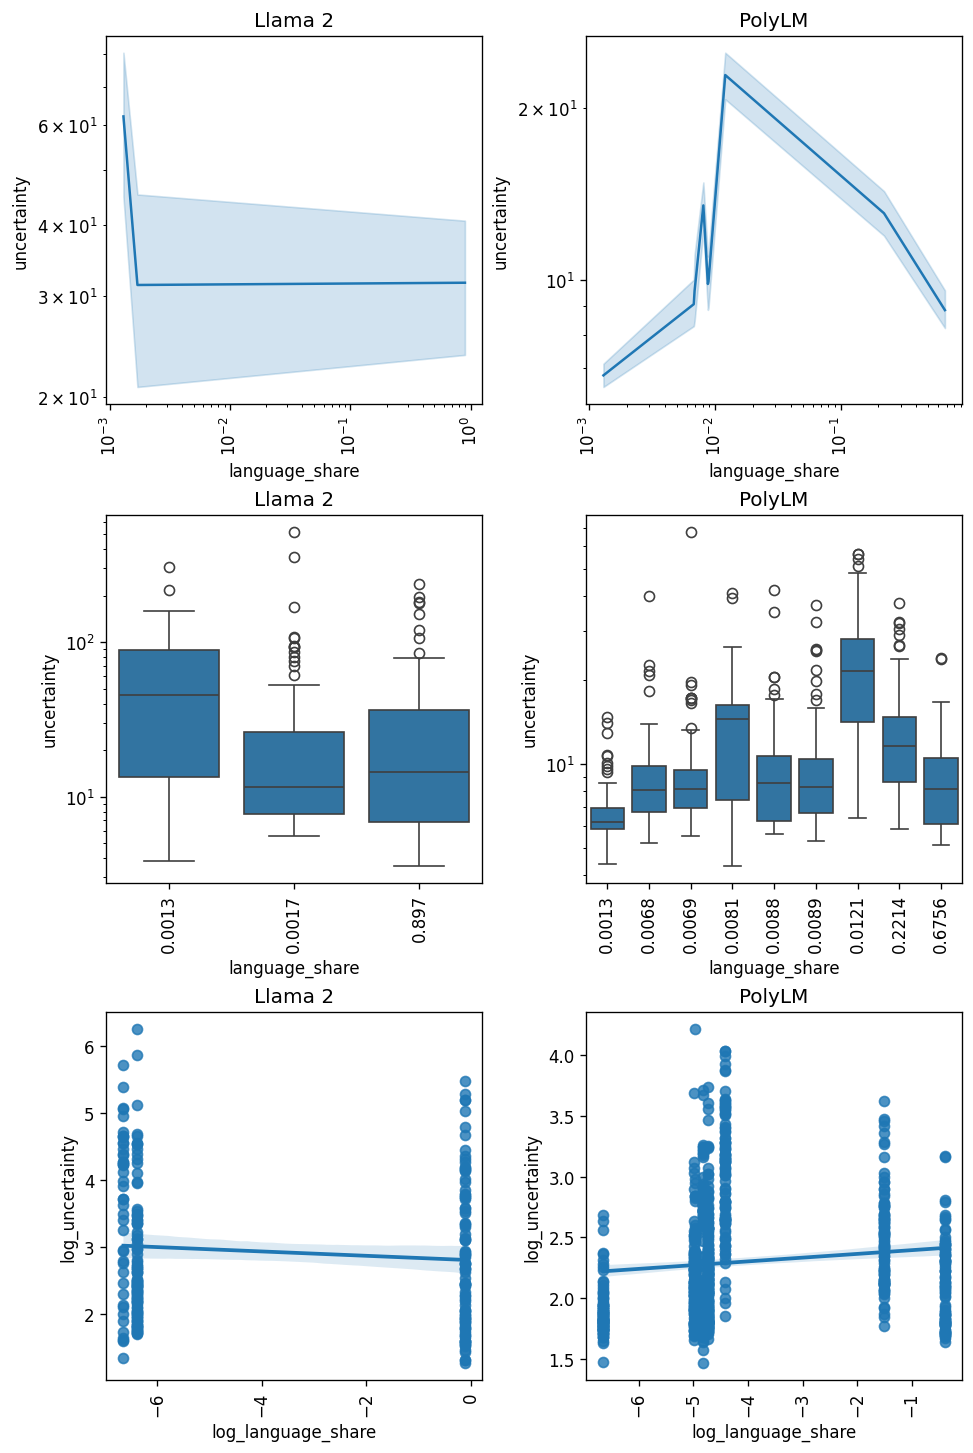

In [99]:
plot_multiling(dfs)

In [100]:
compute_gradient_regressions(dfs)

Regression results for Common Corpus - Llama 2 (log–log):
   uncertainty: coef =  -0.0324, SE = 0.0224, p = 0.1491

Regression results for Common Corpus - PolyLM (log–log):
   uncertainty: coef =   0.0308, SE = 0.0091, p = 0.0007

